# Report: Age Detection Project

*Authors*: Hubert Jaczyński, Maksymilian Knust, Aleksandra Kłos, Aleksandra Lipskaya, Magdalena Leymańczyk

This Jupyter notebook contains our project report: analysis of our training data, evaluation of face recognition algorithm, description of our model and its evaluation. For simplicity, we've decided to use Python exclusively, not only for training, but also for building our GUI app (see `gui.py`). We make extensive use of Python's ecosystem of libraries:

In [1]:
# Standard library
import os, os.path
import warnings
import zipfile
import random
import io
import sys

# Data processing
import numpy as np
import pandas as pd
from tqdm import tqdm

# Graphics
from PIL import Image
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# Training data

The data set was collected from a few different sources on kaggle.com that regarded face or age recognition. It contains photos of faces of people up to 100 years old, in varying quality. To save space, all images are stored inside an archive called `images.zip`. We expect it to be placed in the current directory, unless this notebook is being run on Google Colab:

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    ZIP_PATH = 'images.zip'
else:
    ZIP_PATH = '/content/drive/MyDrive/images.zip'
finally:
    assert os.path.isfile(ZIP_PATH)

Mounted at /content/drive


Loading the data is fairly straightforward:

In [3]:
images = []
labels = []

with zipfile.ZipFile(ZIP_PATH, 'r') as archive:
    for filename in tqdm(archive.namelist()):
        age, gender = map(int, filename.split('_')[:2])
        labels.append((filename, age, gender))

        with archive.open(filename) as file:
            buffer = io.BytesIO()
            Image.open(file).save(buffer, format='JPEG')
            buffer.seek(0)
            images.append(Image.open(buffer))

labels = pd.DataFrame(labels, columns = ['filename', 'age', 'gender'])

100%|██████████| 23708/23708 [00:19<00:00, 1231.97it/s]


Before we proceed, let us shuffle the order of the images. This will prove useful later.

In [4]:
ordered_images = images[:]
labels = labels.sample(frac=1, random_state=1234)
for new_index, old_index in enumerate(labels.index):
    images[new_index] = ordered_images[old_index]
labels = labels.reset_index(drop=True)

## Dataset Analysis

First, let's display a random sample of images, to get a rough idea of the dataset quality. We can see, that some images are blurry or watermarked, but the labels seem accurate.

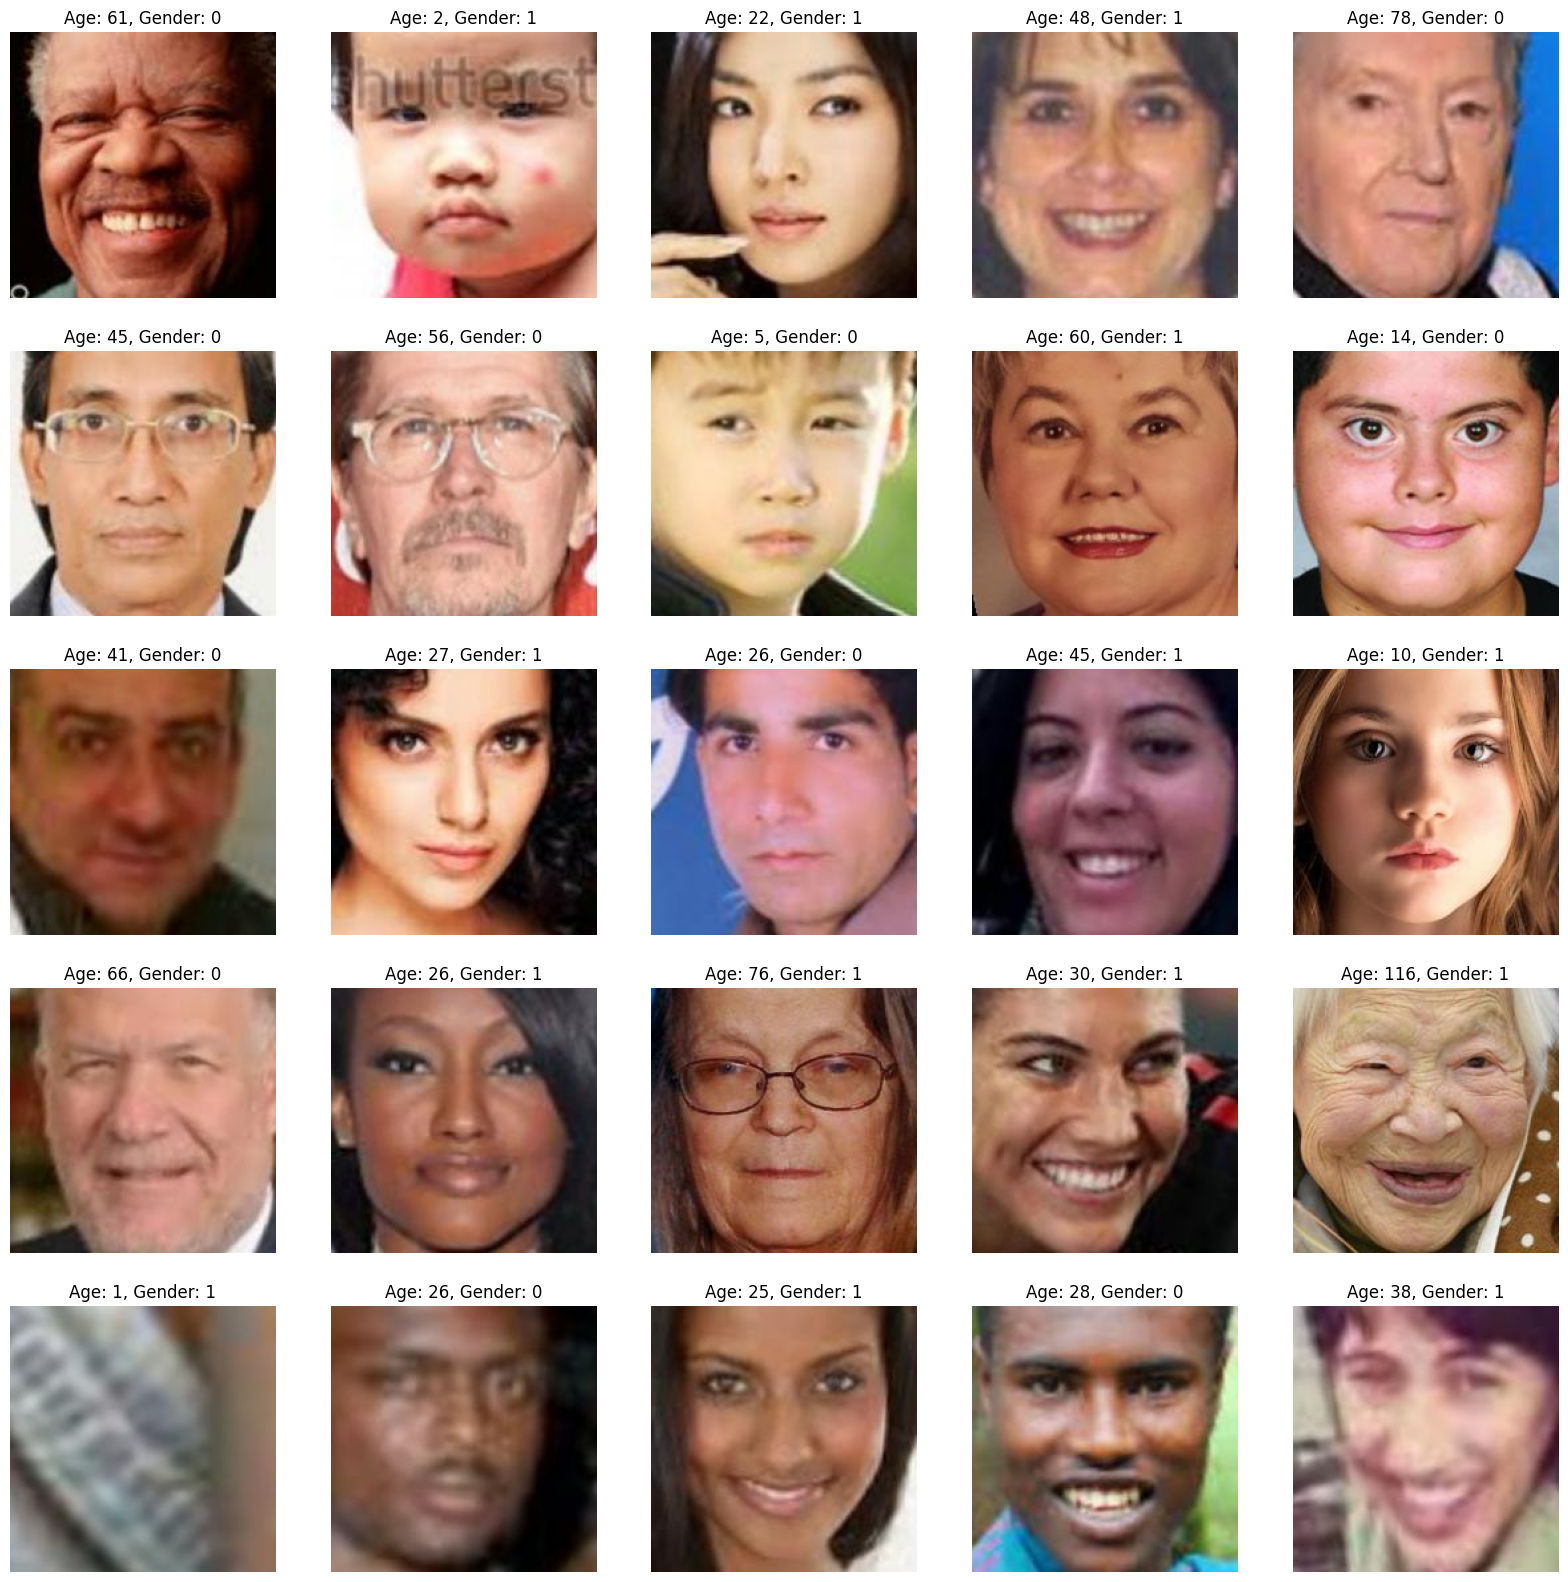

In [ ]:
plt.figure(figsize=(20, 20))
for i, image in enumerate(images[:25]):
    _, age, gender = labels.iloc[i]
    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Age: {age}, Gender: {gender}")
    plt.axis('off')

We can create a histogram, to show the representation of age groups in the dataset.
As can be seen, people in their 20's dominate other age groups.
On the other hand, older people are underrepresented, especially those above 70 y/o.
Both genders are about equally prevalent, however young people have slightly more women then men among them.
Conversely, men make up the majority of older people.

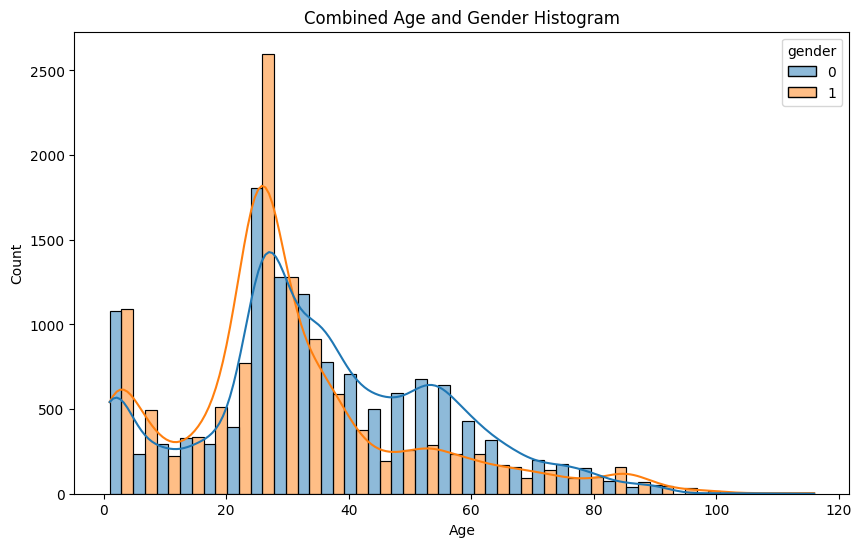

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=labels, x='age', hue='gender', multiple='dodge', ax=ax, bins=30, kde=True)
ax.set_title('Combined Age and Gender Histogram')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

# Face Recognition
## Algorithm Description
In our GUI program, we use the OpenCV library for face recognition:

In [ ]:
import cv2

The algorithm is the Haar Cascade classifier:

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

Below, a function **detect_faces** is presented. It demonstrates the core implementation of face detection in a GUI application using mentioned OpenCV and PyQt5.
It has the following parameters:

 * *self* - a reference to the instance of the class in which this function is defined.
 * *frame* - an image or a single frame from a video stream upon which face and eye detection will be performed. In the contect of OpenCV it is typically a NumPy array representing an image, usually captured from video steam or image file.  
 * *face cascade* - an object of a Haar Cascade Classifier for detecting faces.

In [ ]:
# function for detecting faces in a frame
def detect_faces(self, frame, face_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converting image to grayscale for much better detection
    gray = cv2.GaussianBlur(gray, (5, 5), 0) # preprocessing
    faces = face_cascade.detectMultiScale(gray, 1.1, 5) # detecting faces in the image

    self.faces = faces

    for (x, y, w, h) in faces:
        # draw rectangle around the face
        qp = QPainter(self.image_label.pixmap())
        pen = QPen(Qt.white, 2)
        qp.setPen(pen)
        qp.drawRect(x, y, w, h)
        font = QFont()
        font.setFamily('Times')
        font.setBold(True)
        font.setPointSize(24)
        qp.setFont(font)
        qp.drawText(x, y-10, "Beauty :)")
        qp.end()

At the beginning of the code, the input image (frame) is converted to grayscale. This simplification helps in reducing the complexity for detection algorithms, as color information is not necessary for detecting faces (and eyes). Next, a Gaussian blur is applied to the grayscale image for preprocessing. This can reduce image noise, which can overall improve the performance of the algorithm. Finally, the **detectMultiScale** in-build function is used with the face cascade classifier (*face_cascade*). It detects faces in the image, video or camera. The parameters *scaleFactor=1.1* and *minNeighbors=5* control the detection process.

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converting image to grayscale for much better detection
gray = cv2.GaussianBlur(gray, (5, 5), 0) # preprocessing
faces = face_cascade.detectMultiScale(gray, 1.1, 5) # detecting faces in the image

for (x, y, w, h) in faces:
        # draw rectangle around the face
        qp = QPainter(self.image_label.pixmap())
        pen = QPen(Qt.white, 2)
        qp.setPen(pen)
        qp.drawRect(x, y, w, h)
        font = QFont()
        font.setFamily('Times')
        font.setBold(True)
        font.setPointSize(24)
        qp.setFont(font)
        qp.drawText(x, y-10, "Beauty :)")
        qp.end()

In the above *for loop*, for each detected face (represented by a rectangle with top-left corner (x, y) and width w and height h), a rectangle is drawn around the face, with a label **Beauty :)** is added above it.

## Initial Testing of Face Recognition Algorithm

The initial testing was executed on the sample of 353 photos from UTKFace dataset (https://susanqq.github.io/UTKFace/). It is presented in the following manner:

In [ ]:
import sys
from PyQt5.QtWidgets import QApplication
from PyQt5.QtGui import QPixmap
import cv2
import os
import face_recognition1

class MockLabel:
    def __init__(self):
        self._pixmap = QPixmap(640, 480)  # dummy pixmap for QPainter

    def pixmap(self):
        return self._pixmap

def test_face_detection(dataset_path, face_cascade):
    no_faces = 0
    single_face = 0
    multiple_faces = 0
    total_images = 0

    for filename in os.listdir(dataset_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            total_images += 1
            image_path = os.path.join(dataset_path, filename)
            image = cv2.imread(image_path)

            mock_object = type('', (), {})()
            mock_object.image_label = MockLabel()

            face_recognition1.detect_faces(mock_object, image, face_cascade)
            detected_faces = len(mock_object.faces)

            if detected_faces == 0:
                no_faces += 1
            elif detected_faces == 1:
                single_face += 1
            else:  # more than one face detected
                multiple_faces += 1

    return no_faces, single_face, multiple_faces, total_images

# initialising a QApplication since QPixmap needs it
app = QApplication(sys.argv)

# path to your dataset
dataset_path = 'C:/Users/aleks/OneDrive/Pulpit/utkface' # path (either absolute or relative) can be changed according to the user

# loading face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

no_faces, single_face, multiple_faces, total_images = test_face_detection(dataset_path, face_cascade)
print(f"Total Images: {total_images}")
print(f"No Faces Detected: {no_faces}")
print(f"Single Face Detected: {single_face}")
print(f"Multiple Faces Detected: {multiple_faces}")

Total Images: 353
No Faces Detected: 21
Single Face Detected: 269
Multiple Faces Detected: 63


The **test_face_detection** function was written to evaluate the performance of a face detection algorithm (in this case, based on Haar cascade classifiers) across an images' dataset. The function categorizes each image based on the number of faces detected: no faces, a single face, or multiple faces. The possible outcomes are as follows:

* *Total Images* - a sample image size for the test. Represents the total number of images processed by the function.

* *No Faces Detected* - indicates the number of images where the algorithm detected no faces. If a dataset contains images without faces, this number should be high for those specific images. However, if a dataset consists only of images with faces, a high count could indicate a high rate of false negatives (missing faces that are actually present).

* *Single Face Detected* -  the count of images where exactly one face was detected. If a dataset contains images with a single person on it, a high number would suggest good accuracy of the algorithm. However, if it includes images with multiple people, a high count may indicate that the algorithm is missing additional faces, leading to false negatives.

* *Multiple Face Detected* - the count shows how many images have more than one face detected. As in the chosen dataset there are only single-person images, a high count could indicate false positives (detecting faces where there are none or detecting more faces than actually present).

Based on the test results obtained from 353 images present. In 21 out of them, the algorithm detected no faces. These images were supposed to contain faces, thus these are false negatives (missed detections). Next, the algorithm detected exactly one face in 269 images, whereas 63 of the remaining ones were classified to have multiple faces. Overall, the algorithm seems reasonably accurate with single faces (269 correct detections), but there might be issues with either missing faces (in the 21 no-face detections) or over-detecting faces (in the 63 multiple-faces detections), which needs to be improved further.

## Further Testing of Face Recognition Algorithm

The other testing function, *detect_faces*, is the implementation of the function with the same name, however here the frames are drawn on images differently, since it is not a pixmap. Moreover the images are saved if one or more faces were detected (index is a new parameter the function accepts, which is used for naming the files that are saved).

Additionally, this time we decided to use different dataset - ImageNet100 (https://www.kaggle.com/datasets/ambityga/imagenet100?rvi=1). We also increased the number of pictures in order to obtain more accurate testing results. The function can be found below:

In [ ]:
from PyQt5.QtCore import QFile
def detect_faces(frame, face_cascade, index):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # converting image to grayscale for much better detection
    gray = cv2.GaussianBlur(gray, (5, 5), 0) # preprocessing
    faces = face_cascade.detectMultiScale(gray, 1.1, 5) # detecting faces in the image

    for (x, y, w, h) in faces:
        # draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # save the picture with frame(s) if 1 or more faces were detected
    if(len(faces)>0):
        cv2.imwrite('./'+str(index)+'.JPEG', frame)


The loop which iterates through all pictures in ImageNet100 dataset (which is a dataset containing pictures of mainly not people, but there are human faces too)

In [ ]:
import io
import zipfile

# name of the archive which is in the same folder
zip_archive_path = "images.zip" # path (either absolute or relative) can be changed according to the user
index = 0
face_cascade = cv2.CascadeClassifier(
    "haarcascade_frontalface_default.xml"
)
with zipfile.ZipFile(zip_archive_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith('train'): # those are the folders that we need from the dataset according to documentation
            image_data = zip_ref.read(file)
            nparr = np.frombuffer(image_data, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            detect_faces(img, face_cascade, index)
            index = index+1 # used for naming the image files

As a result of this iteration, 18477 files were saved, from which 1184 really contained faces and the rest did not. Hence for 130000 pictures there were 17293 wrongly detected faces, which is **13,3%** of all pictures.

### Examples of pictures obtained

Correct faces detected:

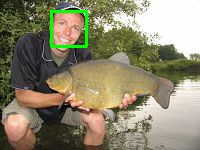
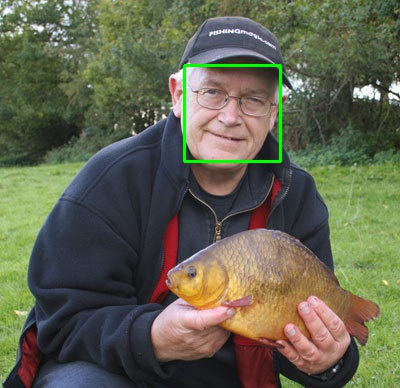


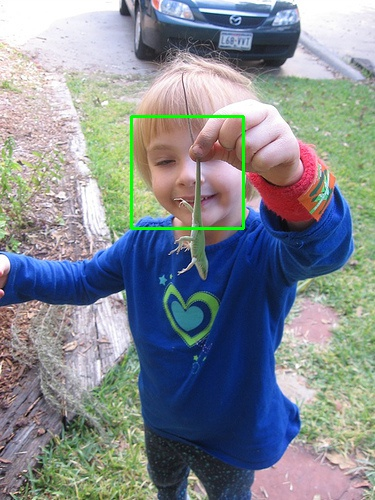
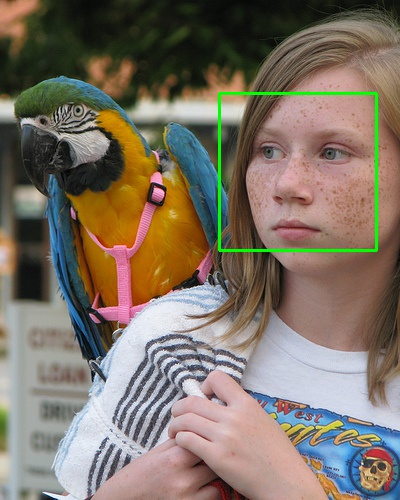

Incorrect detections:

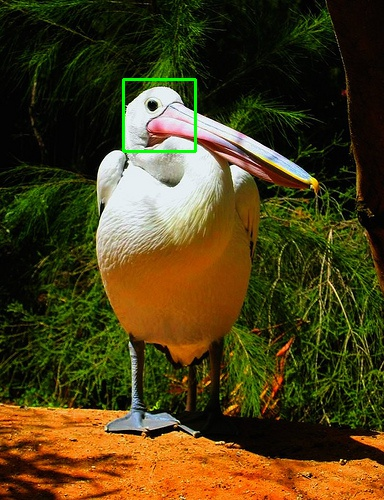
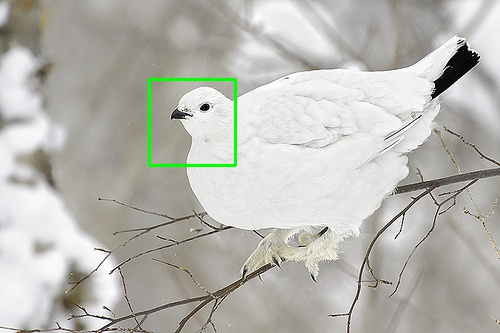


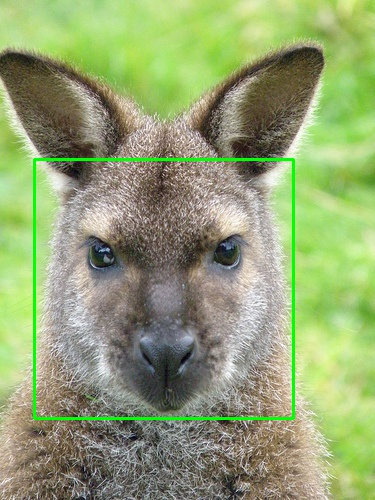
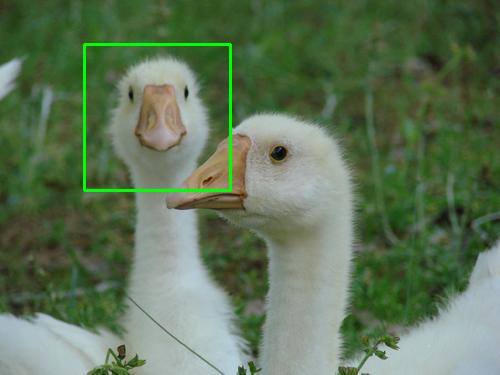

# Data processing
Each JPG image needs to be decompressed, and stored in a NumPy array:

In [5]:
INPUT_SHAPE = (128, 128, 1)

We had also experimented with training our model on images with color, but this not only increased parameter count / training time, but also lead to a greater error at the end. For this reason, we decided to keep converting images into grayscale.

In [6]:
X = np.zeros(((len(images),) + INPUT_SHAPE), dtype='float32')

for i, img in enumerate(tqdm(images)):
    img = img.convert('L') # grayscale
    img = img.resize(INPUT_SHAPE[:2])
    img = np.array(img)
    img.resize(INPUT_SHAPE)
    X[i, :, :, :] = img / 255.0

100%|██████████| 23708/23708 [00:21<00:00, 1112.96it/s]


We also need to split the data into training/testing/validation sets (90%/5%/5%). Note that we've already shuffled the data above. This was done deterministically, so the split will be the same each time the notebook is run.

In [7]:
TESTING_SIZE = VALIDATION_SIZE = len(images) // 20
TRAINING_SIZE = len(images) - TESTING_SIZE - VALIDATION_SIZE

In [8]:
X_train = X[:TRAINING_SIZE, :, :, :]
y_train = labels.age[:TRAINING_SIZE].values

X_test = X[TRAINING_SIZE:-VALIDATION_SIZE, :, :, :]
y_test = labels.age[TRAINING_SIZE:-VALIDATION_SIZE].values

X_val = X[-VALIDATION_SIZE:, :, :, :]
y_val = labels.age[-VALIDATION_SIZE:].values

# Model
Our model is a neural network, built using the Keras library:

In [9]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.layers import RandomFlip, RandomRotation, RandomZoom, BatchNormalization
from keras.callbacks import EarlyStopping

It is fairly similar to other convolutional neural networks, in that it consists of a stack of *convolutional* and *max-pooling* layers, followed by a fully connected layer. The network has one output - we treat age detection as a **regression** problem. We use the *ReLU* activation function, because it avoids the vanishing gradient problem and can be computed very efficiently.  A *dropout* layer helps prevent overfitting. We also use Keras' built-in *data augmentation* capabilities, applying small random distortions to each image.

In [10]:
model = Sequential()

# Data augmentation
model.add(RandomFlip(mode='horizontal'))
model.add(RandomRotation(0.05))
model.add(RandomZoom(0.05))

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='relu', name='age_out'))

# Compiling the model with an optimizer and a loss function
model.compile(optimizer='adam', loss='mean_absolute_error')

We've arrived at our final model architecture, by ~an iterative process~ trial and error. We've found adding an additional convolutional layer increased accuracy, compared to the earlier version. On the other hand, adding new dense layers only caused overfitting. We tried to limit it's effect using layer weight regularization, but those efforts were not fruitful. That's why we stick with just one hidden dense layer.

In [ ]:
model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 126, 126, 32)                    320            
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 126, 126, 32)                    128            
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 63, 63, 32)                      0              
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 61, 61, 64)                      18496          
                                                                       

Keras has the ability to automatically stop training, a few iterations after loss ceases to decrease. It can also store weights with the best loss, and restore this checkpoint once training has finished:

In [11]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                    batch_size=30, callbacks=[early_stop], shuffle=True)

Epoch 1/100
712/712 [==============================] - 41s 43ms/step - loss: 11.0061 - val_loss: 27.3037
Epoch 2/100
712/712 [==============================] - 29s 40ms/step - loss: 8.9376 - val_loss: 13.2989
Epoch 3/100
712/712 [==============================] - 29s 41ms/step - loss: 8.3553 - val_loss: 8.6628
Epoch 4/100
712/712 [==============================] - 30s 42ms/step - loss: 7.8438 - val_loss: 9.7534
Epoch 5/100
712/712 [==============================] - 30s 42ms/step - loss: 7.4791 - val_loss: 7.5317
Epoch 6/100
712/712 [==============================] - 30s 42ms/step - loss: 7.2631 - val_loss: 6.6519
Epoch 7/100
712/712 [==============================] - 29s 41ms/step - loss: 6.9877 - val_loss: 6.8503
Epoch 8/100
712/712 [==============================] - 30s 42ms/step - loss: 6.7822 - val_loss: 7.9788
Epoch 9/100
712/712 [==============================] - 29s 41ms/step - loss: 6.6663 - val_loss: 6.5035
Epoch 10/100
712/712 [==============================] - 29s 41ms/step 

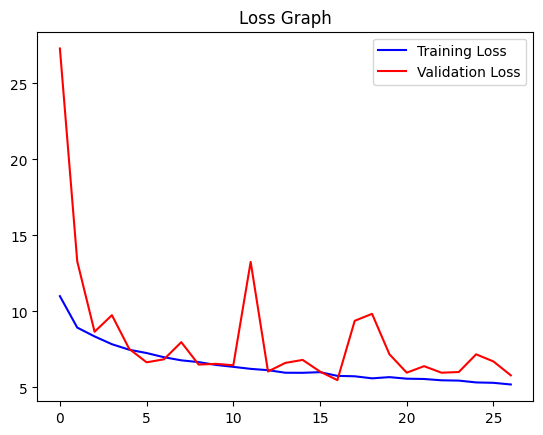

In [13]:
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], 'b', label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Let's see how our model performs on a few examples:

In [14]:
def show_prediction(index):
    print("Original Age:", y_test[index])
    pred_age = model.predict(X_test[index].reshape(1, 128, 128, 1), verbose=0)[0, 0]
    print("Predicted Age:", pred_age)
    plt.axis('off')
    plt.imshow(X_test[index].reshape(128, 128), cmap='gray')

Original Age: 37
Predicted Age: 37.90788


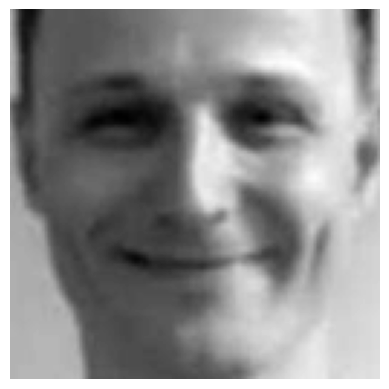

In [16]:
show_prediction(1)

Original Age: 27
Predicted Age: 30.978434


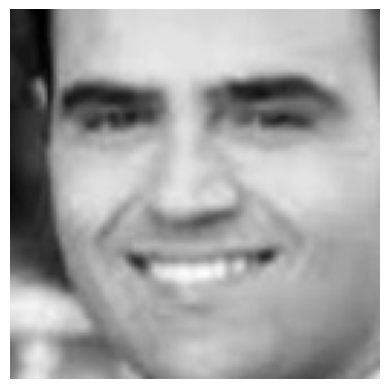

In [17]:
show_prediction(2)

Original Age: 54
Predicted Age: 33.92696


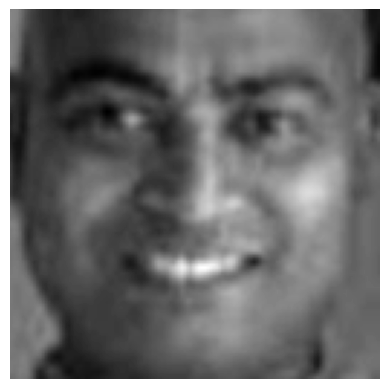

In [18]:
show_prediction(3)

Finally, we can calculate the Mean Absolute Error on our testing dataset:

In [19]:
from sklearn.metrics import mean_absolute_error

predicted_ages = []
for i in range(len(X_test)):
    pred_age = model.predict(X_test[i].reshape(1, 128, 128, 1), verbose=0)[0, 0]
    predicted_ages.append(pred_age)

mae = mean_absolute_error(predicted_ages, y_test)
print("Mean Absolute Error for Age Prediction:", mae)

Mean Absolute Error for Age Prediction: 5.446020646286414


In [20]:
model.save("age_model.keras")